# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os


2024-03-09 01:00:28.749115: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 01:00:28.828042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 01:00:28.828070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 01:00:28.839550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 01:00:28.864306: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

/home/big/Kevin/Workspace/Homework/ecec147/project/Deep-Learning-EEG-BCI-Signal-Processing/EEG-Data


(2115, 22, 1000)


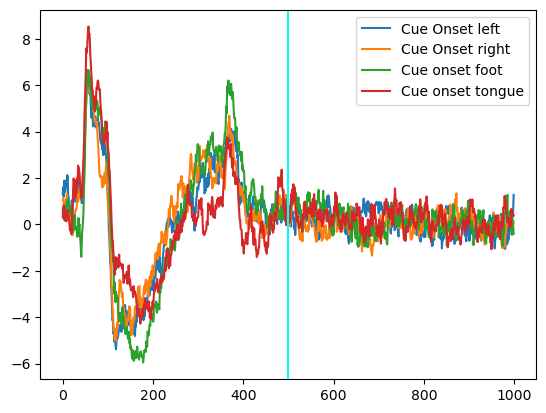

In [3]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






# Data Preprocessing

In [4]:

def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (250, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (250, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460,

# CNN Model Architecture

In [5]:
from EEG_CNN import CNN
from EEG_ResNet import ResNetCustom

In [6]:
import itertools
from keras.utils import plot_model
# Building the CNN model using sequential class
reg = {'reg 1e-2': 1e-2}
filters = {'3x1 filter': 3, '5x1 filter': 5, '7x1 filter' : 7}
convdepth = {'8 convlayers': 8, '9 convlayers':9, '10 convlayers': 10}
pool = {'pool 2': 2, 'pool 3': 3}
dropout = {'dropout 0.4': 0.4, 'dropout 0.5': 0.5, 'dropout 0.6': 0.6}
hyperparams = [reg, filters, convdepth, pool, dropout]

# resnet = ResNetCustom()
# resnet.summary()
models_names = []
# models = [ResNetCustom(reg=0.01, pool_size=3, dropout=0.5, first_conv_num=25, first_conv_size=5,
#                        res_filter_sizes=[5 for _ in range(10)],
#                        res_num_filters=[min(200, 25 * (2 ** i)) for i in range(10)])]
models = []

for a in itertools.product(*[hyperparam.items() for hyperparam in hyperparams]):
    models_names.append([i[0] for i in a])
    models.append(ResNetCustom(reg = a[0][1], res_filter_sizes=[a[1][1] for _ in range(a[2][1])],
                               res_num_filters=[min(200, 25 * (2 ** i)) for i in range(a[2][1])],
                               pool_size=a[3][1],
                               dropout=a[4][1]))
# plot_model(models[0], to_file='../Gallery/ResNetCustom.png', show_shapes=True, show_layer_names=True)
# for a in itertools.product(mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()):
#     models_names.append([i[0] for i in a])
#     models.append(CNN(input_shape=(400,1,22), use_max_pool=a[0][1], reg=a[1][1], dropout_on_conv=a[2][1], 
#                       filters=[a[3][1] for _ in range(a[4][1])],
#                       num_filters=[min(200, 25 * (2 ** i)) for i in range(a[4][1])]))

# Printing the model summary
# basic_cnn_model.summary()


2024-03-09 01:00:32.470846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 01:00:32.541909: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 01:00:32.542275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Train CNN Model

In [7]:
# Model parameter
# learning_rate = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps)
learning_rate = 5e-3

epochs = 300
# cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
# Compiling the model
from keras.callbacks import ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
for model in models:
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
histories = []
for i, (model, model_name) in enumerate(zip(models, models_names)):
# Training and validating the model
    print(f"Training model {i+1} / {len(models)}:")
    print(model_name)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=5, min_lr=3e-5)
    histories.append(model.fit(x_train,
             y_train,
             batch_size=256,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[reduce_lr],
             verbose=False)
    )



Training model 1 / 54:
['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 01:01:00.035974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-09 01:01:00.626867: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-09 01:01:02.519076: I external/local_xla/xla/service/service.cc:168] XLA service 0x7cfa716fa190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-09 01:01:02.519107: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-09 01:01:02.535936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709974862.647740    2465 device_compiler.h:186] Compiled cluster us

Training model 2 / 54:
['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 01:05:25.583316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 3 / 54:
['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 01:09:41.892568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 4 / 54:
['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 01:13:59.805725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 5 / 54:
['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 01:17:41.412931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 6 / 54:
['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 01:21:22.608982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 7 / 54:
['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 01:25:04.408207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 8 / 54:
['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 01:29:37.282663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_64/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 9 / 54:
['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 01:33:54.058184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_74/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 10 / 54:
['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 01:38:03.841288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_84/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 11 / 54:
['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 01:41:33.536903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_94/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 12 / 54:
['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 01:45:01.058583: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_104/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 13 / 54:
['reg 1e-2', '3x1 filter', '10 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 01:48:29.606917: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_114/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 14 / 54:
['reg 1e-2', '3x1 filter', '10 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 01:52:50.165986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_125/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 15 / 54:
['reg 1e-2', '3x1 filter', '10 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 01:57:09.752005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_136/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 16 / 54:
['reg 1e-2', '3x1 filter', '10 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 02:01:29.765946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_147/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 17 / 54:
['reg 1e-2', '3x1 filter', '10 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 02:05:01.051719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/dropout_158/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 18 / 54:
['reg 1e-2', '3x1 filter', '10 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 02:08:38.576826: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_17/dropout_169/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 19 / 54:
['reg 1e-2', '5x1 filter', '8 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 02:12:13.864242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_18/dropout_180/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-09 02:12:21.119687: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 02:12:21.155699: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Training model 20 / 54:
['reg 1e-2', '5x1 filter', '8 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 02:16:39.245223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_19/dropout_189/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 21 / 54:
['reg 1e-2', '5x1 filter', '8 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 02:20:59.565032: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/dropout_198/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 22 / 54:
['reg 1e-2', '5x1 filter', '8 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 02:25:15.931236: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_207/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 23 / 54:
['reg 1e-2', '5x1 filter', '8 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 02:28:35.128183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/dropout_216/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 24 / 54:
['reg 1e-2', '5x1 filter', '8 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 02:31:56.890025: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_225/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 25 / 54:
['reg 1e-2', '5x1 filter', '9 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 02:35:17.997703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_24/dropout_234/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 26 / 54:
['reg 1e-2', '5x1 filter', '9 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 02:39:48.933697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_25/dropout_244/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 27 / 54:
['reg 1e-2', '5x1 filter', '9 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 02:44:22.781677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_26/dropout_254/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 28 / 54:
['reg 1e-2', '5x1 filter', '9 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 02:48:56.310704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_27/dropout_264/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 29 / 54:
['reg 1e-2', '5x1 filter', '9 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 02:52:24.361030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_28/dropout_274/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 30 / 54:
['reg 1e-2', '5x1 filter', '9 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 02:55:55.414673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_29/dropout_284/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 31 / 54:
['reg 1e-2', '5x1 filter', '10 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 02:59:21.536613: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_30/dropout_294/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 32 / 54:
['reg 1e-2', '5x1 filter', '10 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 03:04:06.470764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_31/dropout_305/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 33 / 54:
['reg 1e-2', '5x1 filter', '10 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 03:08:53.531530: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_32/dropout_316/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 34 / 54:
['reg 1e-2', '5x1 filter', '10 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 03:13:39.500726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_33/dropout_327/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 35 / 54:
['reg 1e-2', '5x1 filter', '10 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 03:17:19.017220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_34/dropout_338/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 36 / 54:
['reg 1e-2', '5x1 filter', '10 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 03:20:55.869756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_35/dropout_349/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 37 / 54:
['reg 1e-2', '7x1 filter', '8 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 03:24:36.747773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_36/dropout_360/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-09 03:24:43.188295: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 03:24:43.257666: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 03:24:44.222058: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran

Training model 38 / 54:
['reg 1e-2', '7x1 filter', '8 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 03:29:27.045657: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_37/dropout_369/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 39 / 54:
['reg 1e-2', '7x1 filter', '8 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 03:34:11.257047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_38/dropout_378/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 40 / 54:
['reg 1e-2', '7x1 filter', '8 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 03:38:55.902097: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_39/dropout_387/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-09 03:39:01.573827: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 03:39:01.605806: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Training model 41 / 54:
['reg 1e-2', '7x1 filter', '8 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 03:42:21.872730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_40/dropout_396/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 42 / 54:
['reg 1e-2', '7x1 filter', '8 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 03:45:41.297546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_41/dropout_405/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 43 / 54:
['reg 1e-2', '7x1 filter', '9 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 03:49:02.158567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_42/dropout_414/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 44 / 54:
['reg 1e-2', '7x1 filter', '9 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 03:54:01.820849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_43/dropout_424/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 45 / 54:
['reg 1e-2', '7x1 filter', '9 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 03:58:57.158433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_44/dropout_434/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 46 / 54:
['reg 1e-2', '7x1 filter', '9 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 04:03:53.189667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_45/dropout_444/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 47 / 54:
['reg 1e-2', '7x1 filter', '9 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 04:07:23.455052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_46/dropout_454/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 48 / 54:
['reg 1e-2', '7x1 filter', '9 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 04:10:49.751426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_47/dropout_464/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 49 / 54:
['reg 1e-2', '7x1 filter', '10 convlayers', 'pool 2', 'dropout 0.4']


2024-03-09 04:14:21.401455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_48/dropout_474/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 50 / 54:
['reg 1e-2', '7x1 filter', '10 convlayers', 'pool 2', 'dropout 0.5']


2024-03-09 04:19:34.126096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_49/dropout_485/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 51 / 54:
['reg 1e-2', '7x1 filter', '10 convlayers', 'pool 2', 'dropout 0.6']


2024-03-09 04:24:43.495632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_50/dropout_496/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 52 / 54:
['reg 1e-2', '7x1 filter', '10 convlayers', 'pool 3', 'dropout 0.4']


2024-03-09 04:29:56.327849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_51/dropout_507/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 53 / 54:
['reg 1e-2', '7x1 filter', '10 convlayers', 'pool 3', 'dropout 0.5']


2024-03-09 04:33:43.228188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_52/dropout_518/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training model 54 / 54:
['reg 1e-2', '7x1 filter', '10 convlayers', 'pool 3', 'dropout 0.6']


2024-03-09 04:37:27.988870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_53/dropout_529/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


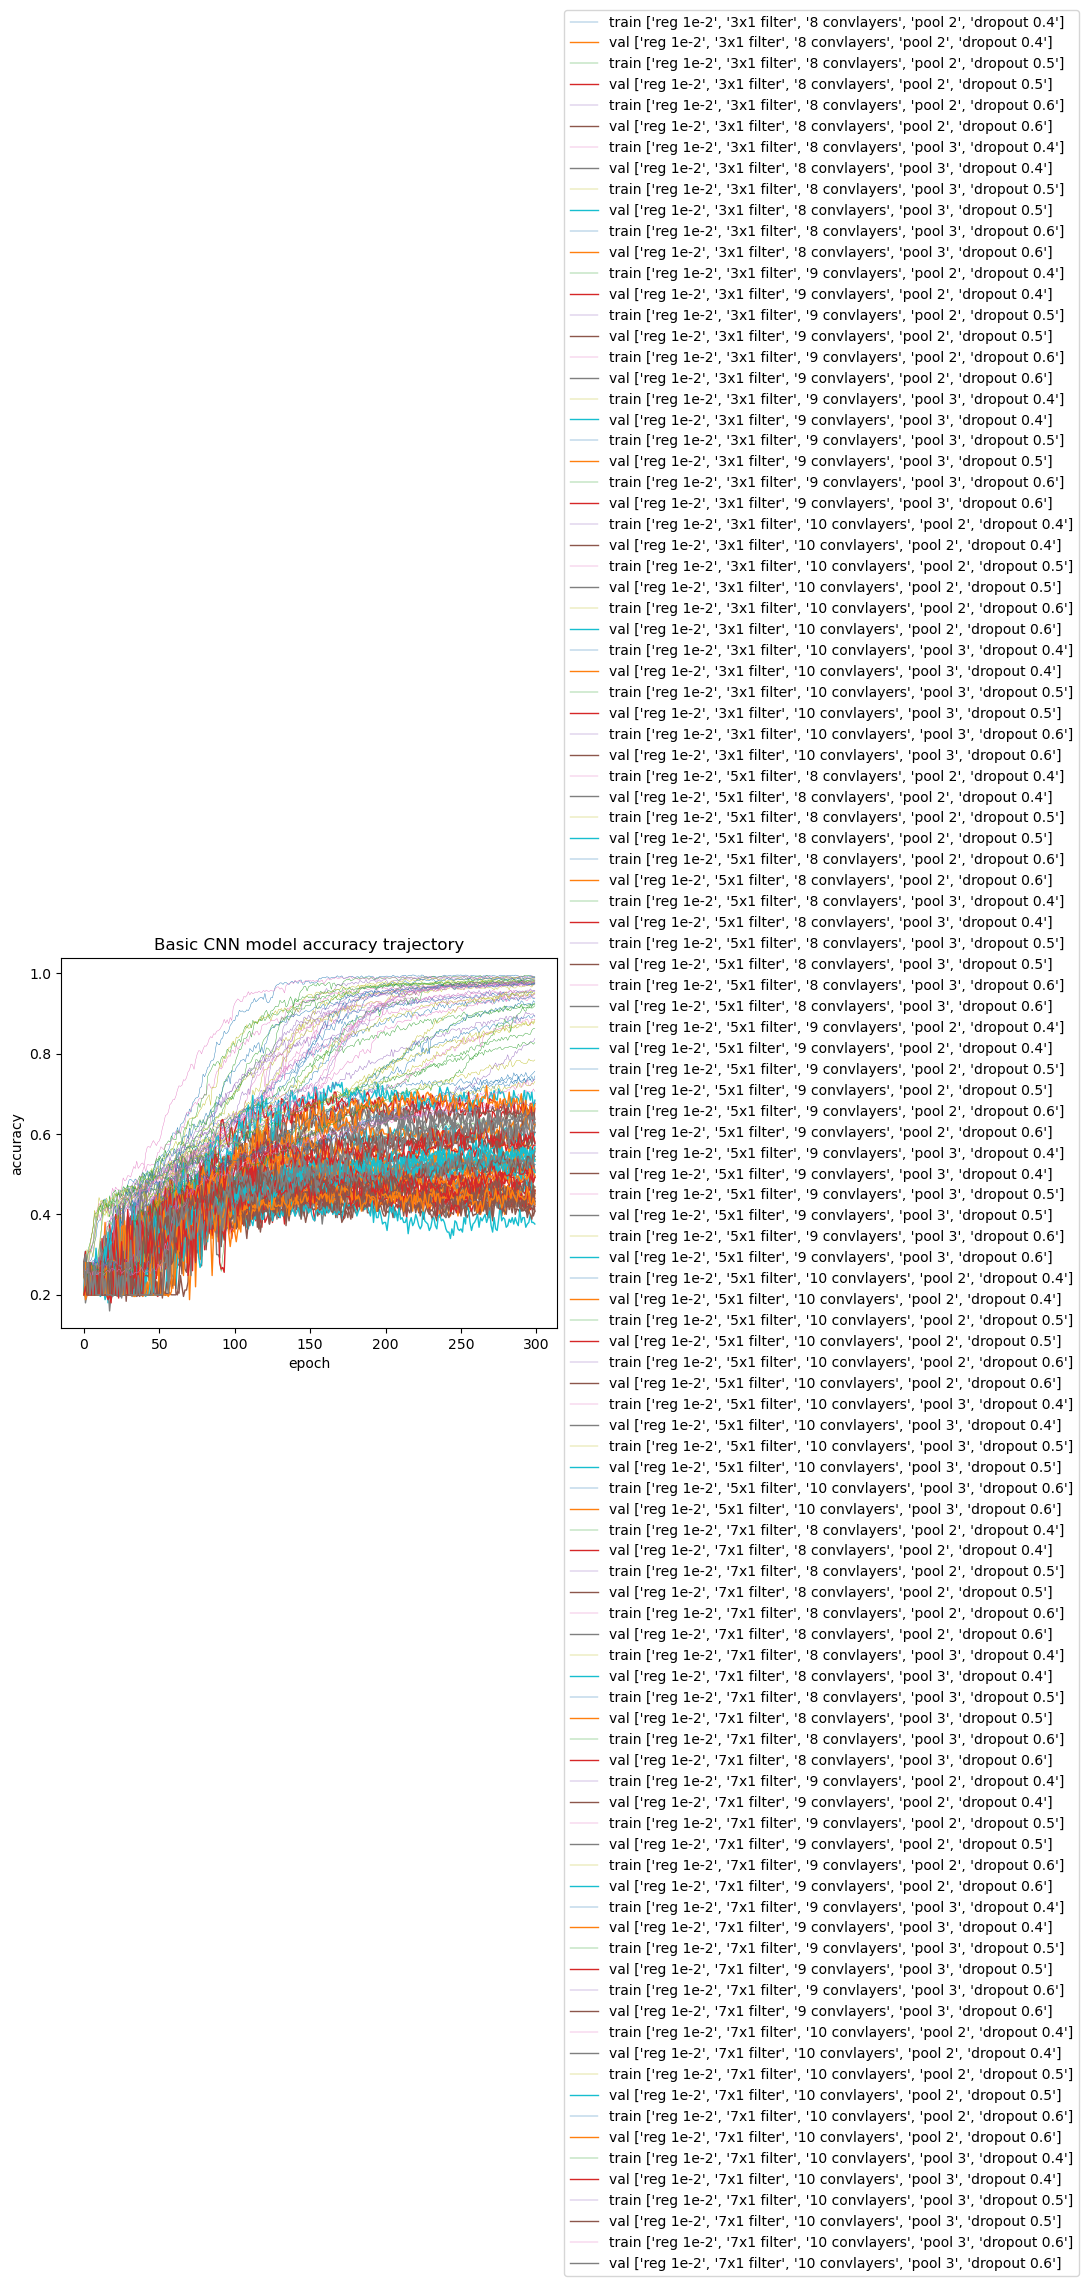

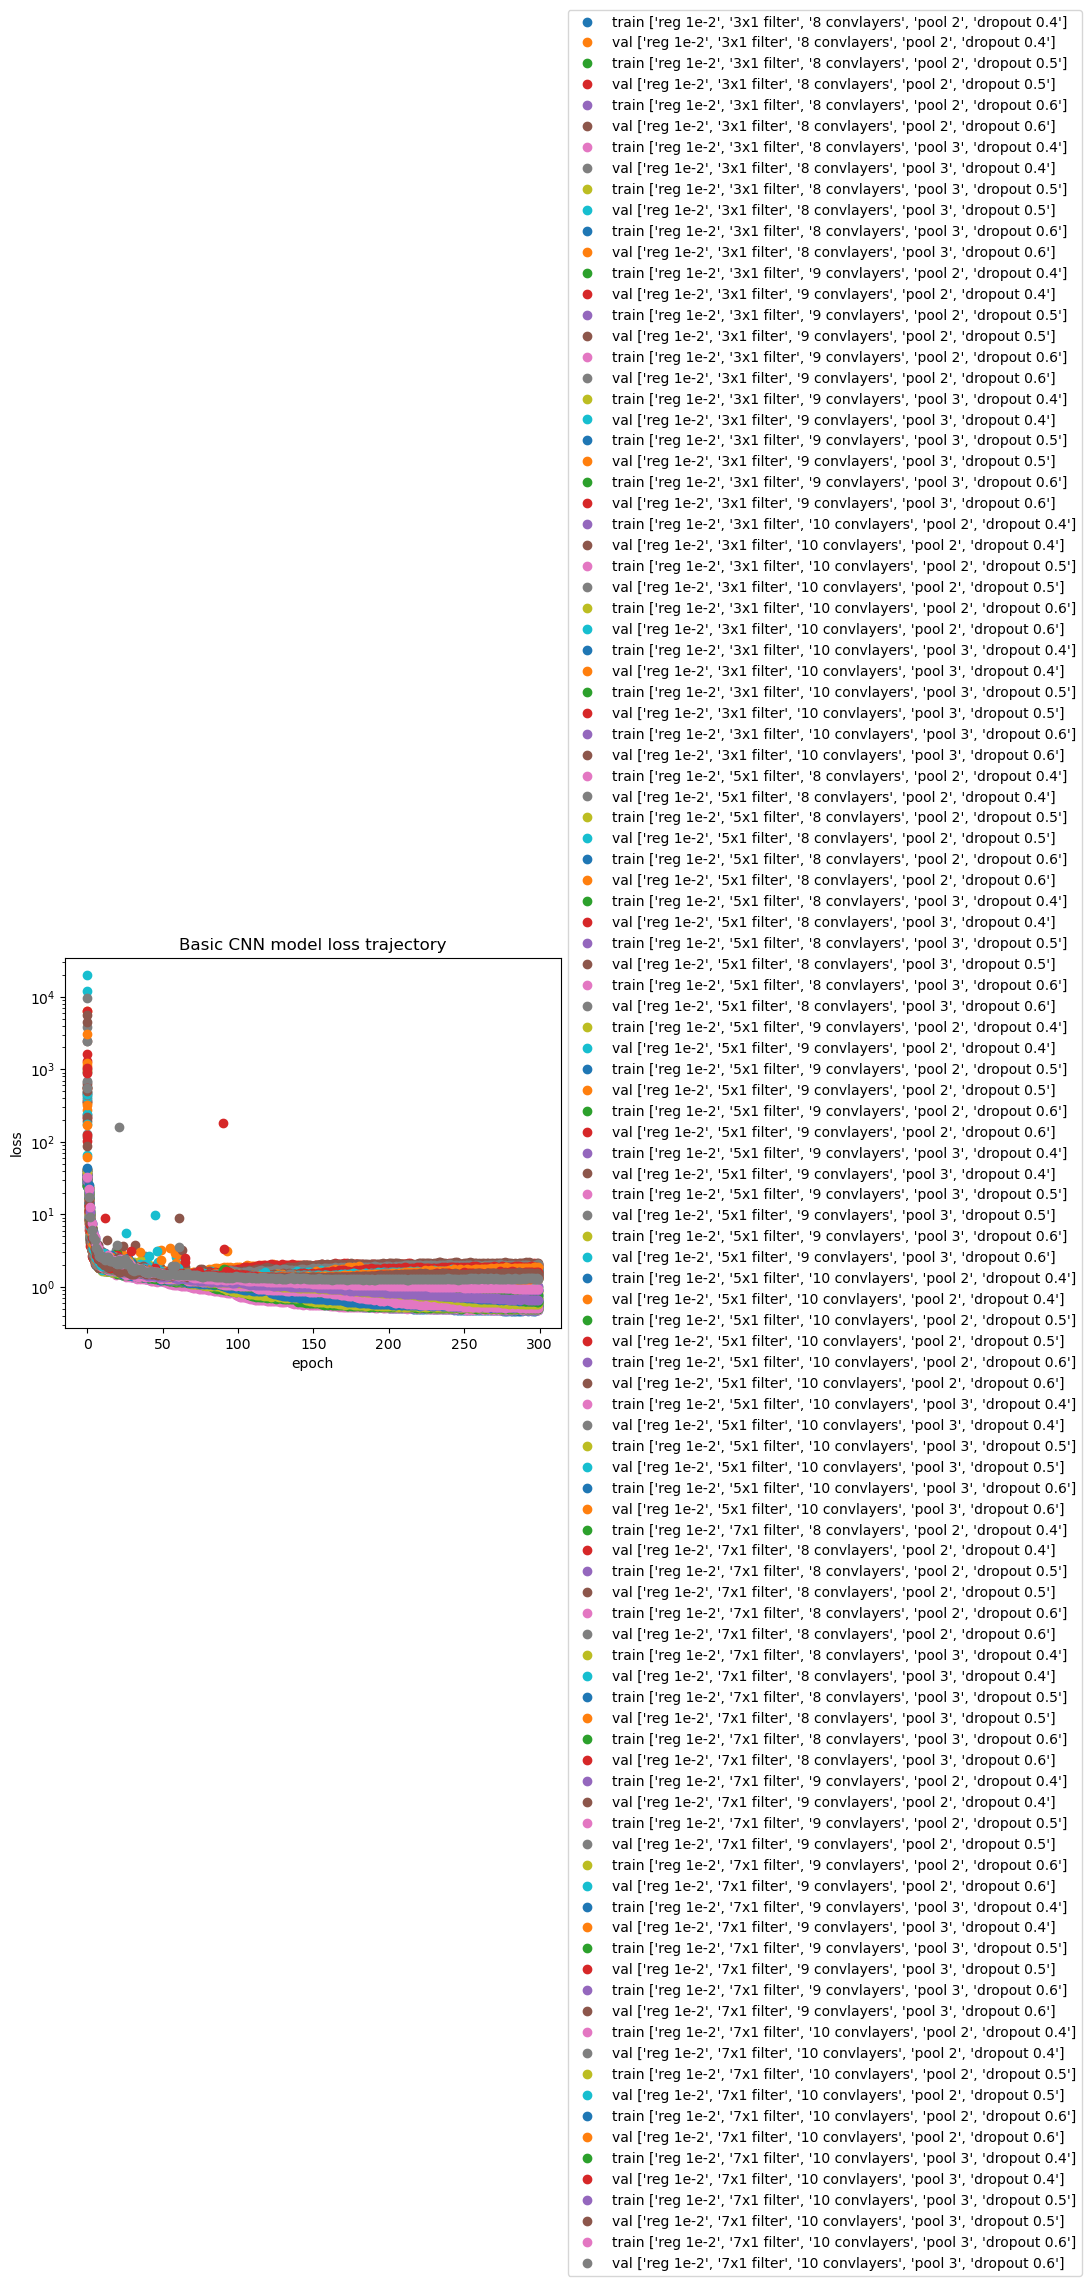

In [9]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
for hist in histories:
    plt.plot(hist.history['accuracy'], linewidth=0.3)
    plt.plot(hist.history['val_accuracy'], linewidth=1)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
labels = []
for name in models_names:
    labels.append(f'train {name}')
    labels.append(f'val {name}')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
for hist in histories:
    plt.plot(hist.history['loss'],'o')
    plt.plot(hist.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
## Testing the basic CNN model

for model_, name in zip(models, models_names):
    cnn_score = model_.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy of {name}:',cnn_score[1])


Test accuracy of ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.4']: 0.44018059968948364
Test accuracy of ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.5']: 0.45372459292411804


Test accuracy of ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.6']: 0.3882618546485901
Test accuracy of ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.4']: 0.4920993149280548
Test accuracy of ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.5']: 0.4808126389980316
Test accuracy of ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.6']: 0.4762979745864868
Test accuracy of ['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 2', 'dropout 0.4']: 0.3792324960231781
Test accuracy of ['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 2', 'dropout 0.5']: 0.43340858817100525
Test accuracy of ['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 2', 'dropout 0.6']: 0.4040631949901581
Test accuracy of ['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 3', 'dropout 0.4']: 0.5011286735534668
Test accuracy of ['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 3', 'dropout 0.5']: 0.4808126389980316
Test accuracy of ['reg 1e-2', '3x1 filter', '9 convlay

In [11]:
from keras.models import save_model
from keras.utils import plot_model

# Save entire model
# model_filename = f'../Models/Custom_Resnet{cnn_score[1]}.h5'
# model.save(model_filename)

# Save weights only
# weights_filename = f'../Models/Custom_Resnet{cnn_score[1]}.h5'
# model.save_weights(weights_filename)
# Load weights into a new model with the same architecture
# loaded_model = create_resnet_lstm_model() # create using resnet-15 architecture
# loaded_model.load_weights(weights_filename)

In [12]:
maxes_ = []
finals_ = []
for hist, name in zip(histories, models_names):
    maxes_.append(max(hist.history['val_accuracy']))
    finals_.append(hist.history['val_accuracy'][-1])
    print(f"Validation accuracy {name}: max: {max(hist.history['val_accuracy'])}, final: {hist.history['val_accuracy'][-1]}")
for pair in sorted(zip(finals_, models_names), key=lambda i: i[0], reverse=True):
    print(pair)

Validation accuracy ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.4']: max: 0.47200000286102295, final: 0.4480000138282776
Validation accuracy ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.5']: max: 0.5120000243186951, final: 0.46000000834465027
Validation accuracy ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 2', 'dropout 0.6']: max: 0.5, final: 0.42800000309944153
Validation accuracy ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.4']: max: 0.5640000104904175, final: 0.492000013589859
Validation accuracy ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.5']: max: 0.5360000133514404, final: 0.46000000834465027
Validation accuracy ['reg 1e-2', '3x1 filter', '8 convlayers', 'pool 3', 'dropout 0.6']: max: 0.4959999918937683, final: 0.4519999921321869
Validation accuracy ['reg 1e-2', '3x1 filter', '9 convlayers', 'pool 2', 'dropout 0.4']: max: 0.47200000286102295, final: 0.41999998688697815
Validation accuracy ['reg 1e-2

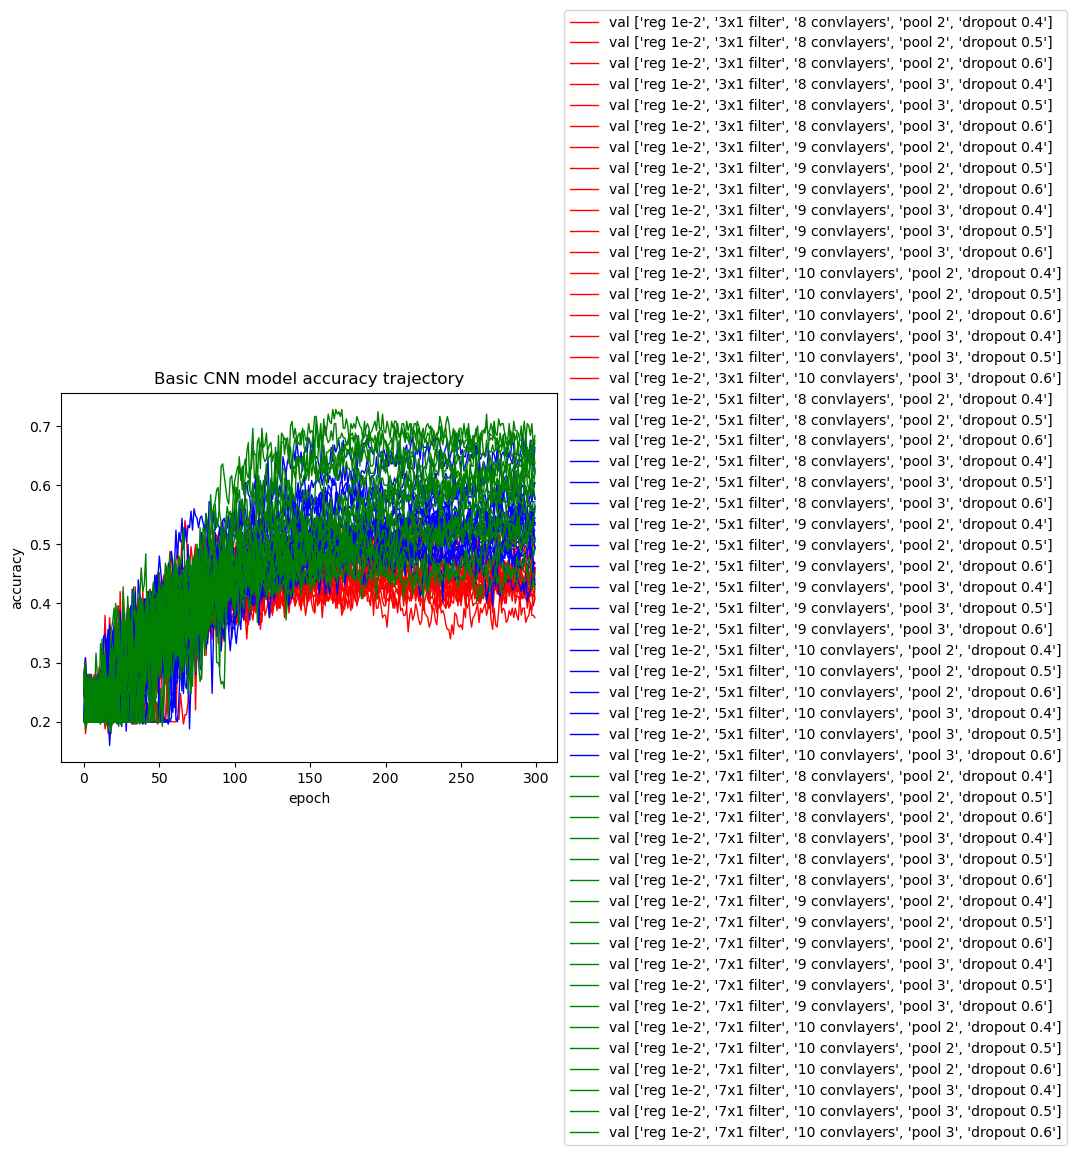

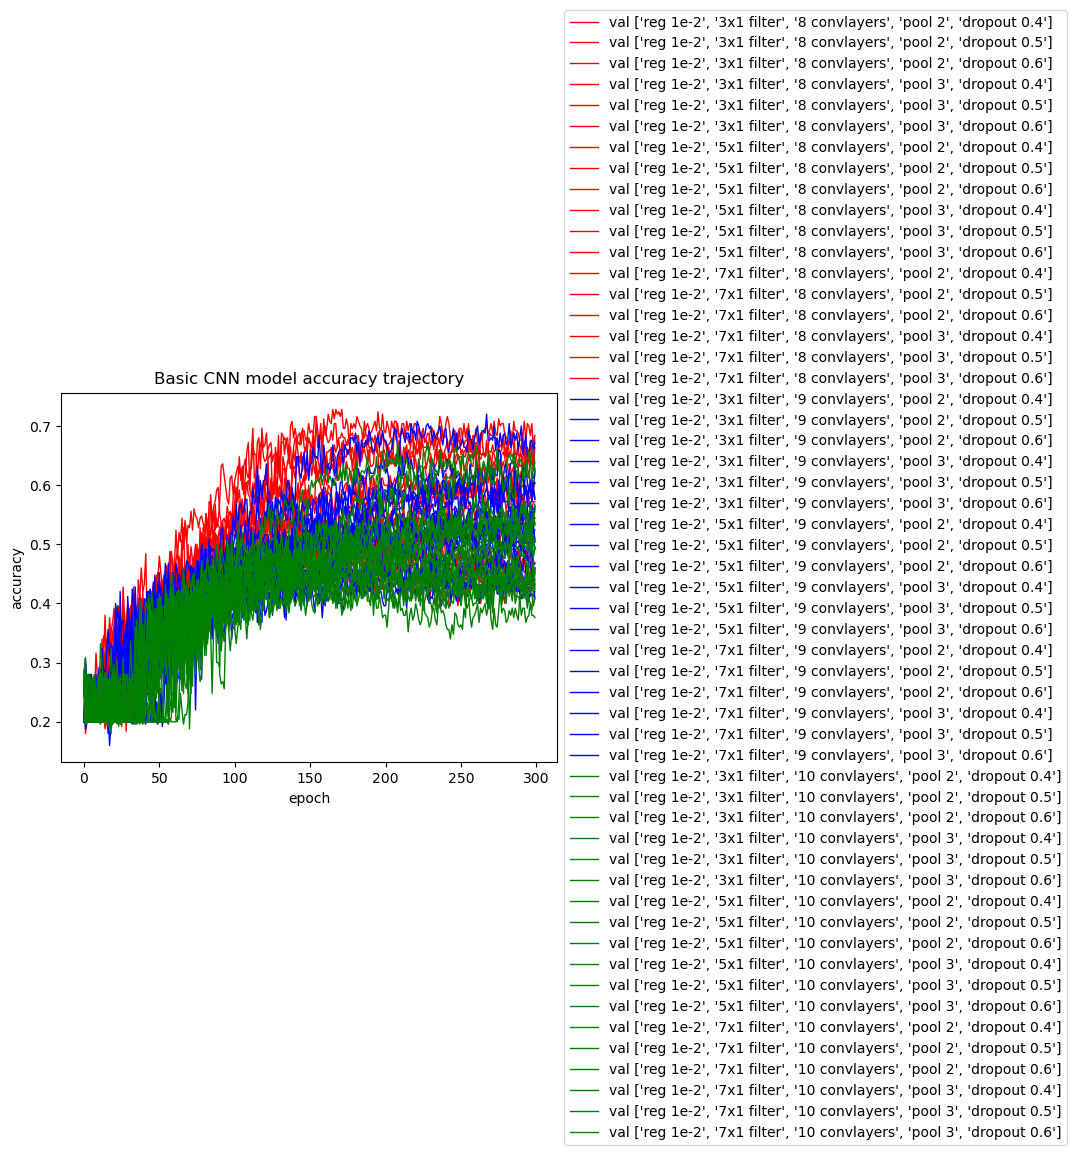

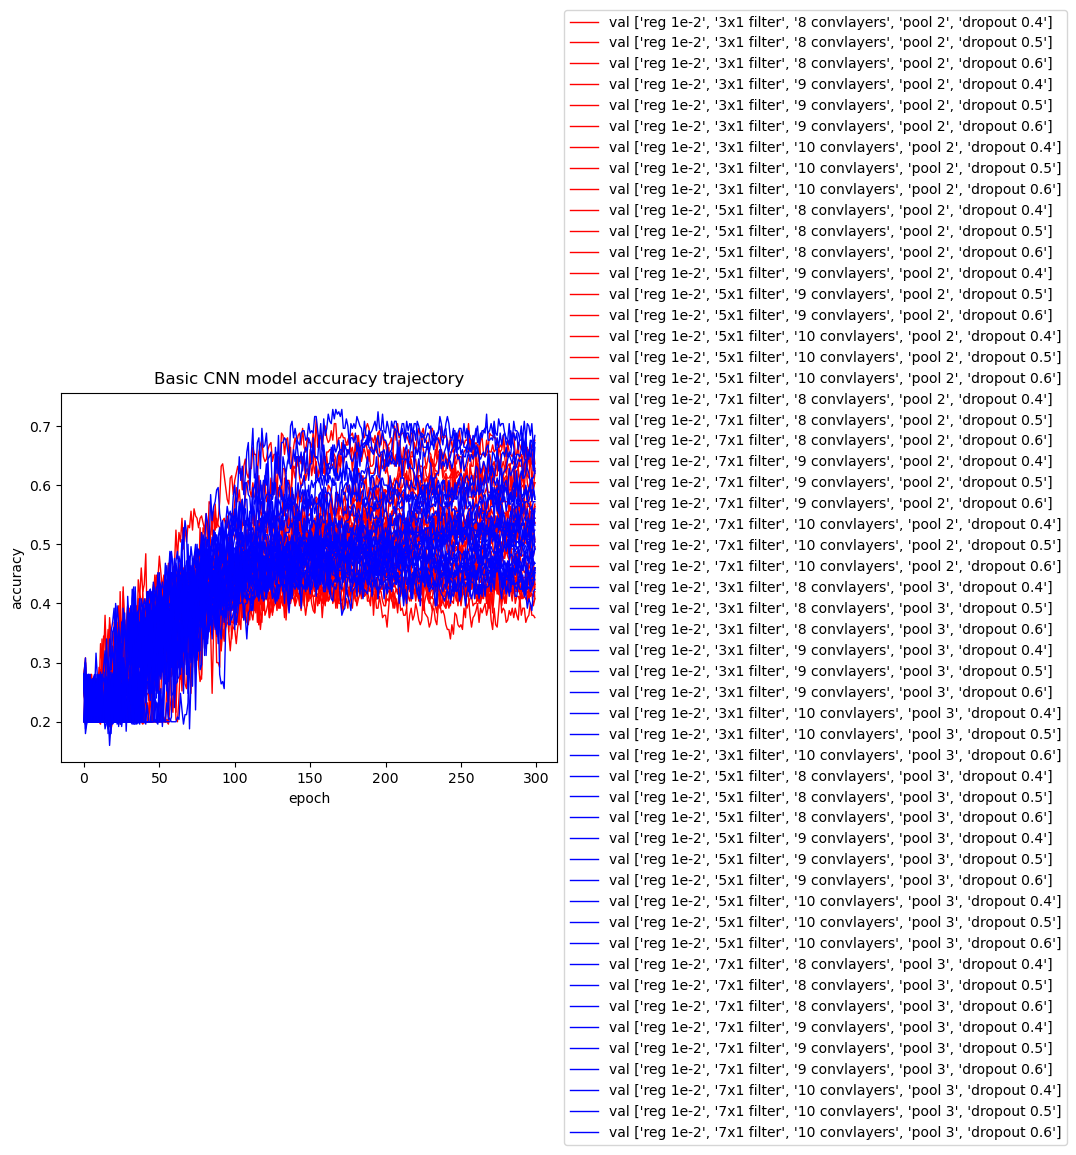

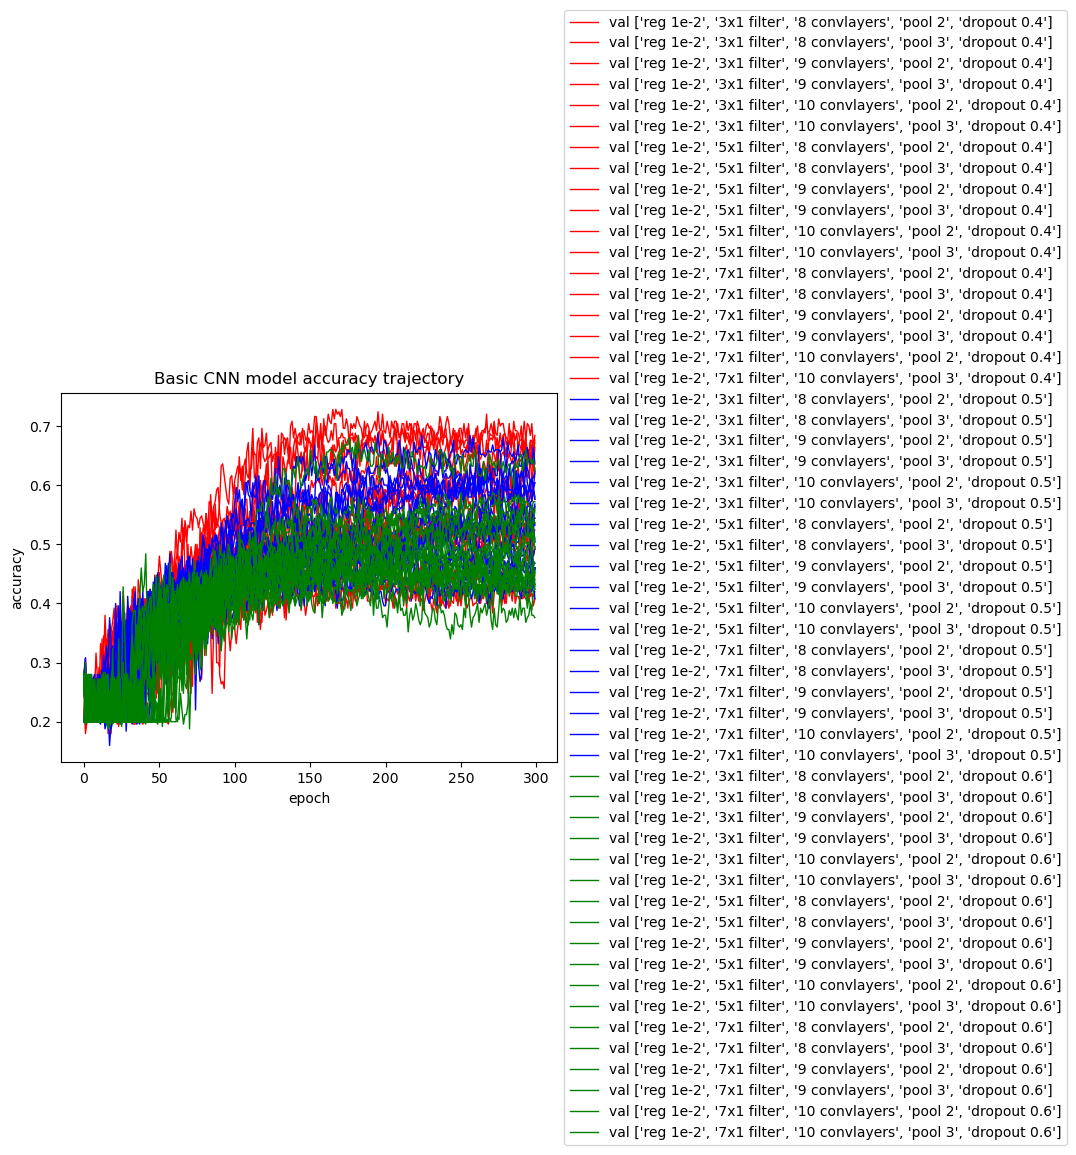

In [13]:
color = ['r', 'b', 'g']
for param in [h.items() for h in hyperparams]:
    if len(param) == 1:
        continue
    for i, param_name in enumerate(param):
        for name, label, history in zip(models_names, labels[1::2], histories):
            if param_name[0] in name:
                plt.plot(history.history['val_accuracy'], linewidth=1, color=color[i], label=label)
    plt.title('Basic CNN model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()